In [438]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [439]:
factor = pd.read_csv("FACTOR.csv",index_col=0)
# factor.head()


In [440]:
fmrtn = pd.read_csv("FMRTN1W.csv",index_col=0)
#fmrtn.head(10)

/Users/zengzheng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


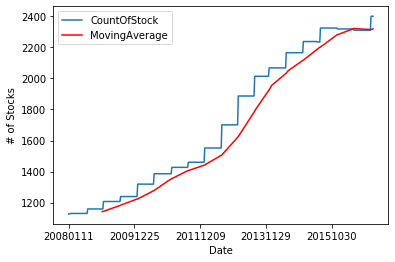

In [442]:
#coverage
coverage = factor.count()[1:]
Coverage = pd.DataFrame(coverage,columns = ['CountOfStock'])
Coverage["MovingAverage"] = np.nan
for i in range(51,len(Coverage)):
    Coverage["MovingAverage"][i]=round(coverage[i-51:i].mean(),0)
Coverage.head(20)
Coverage['CountOfStock'].plot(grid=False)
plt.ylabel("# of Stocks")
plt.xlabel("Date")
Coverage['MovingAverage'].plot(color = "red")
plt.legend(loc = "upper left")

In [306]:
#strategy returns
factor2 = pd.read_csv("FACTOR.csv",index_col=0).T
freturn = pd.read_csv("FMRTN1W.csv",index_col=0).T
#extract date index
f = lambda x : datetime.strptime(x,'%Y%m%d')
factor2.index = (pd.Series(factor2.index)).apply(f)
freturn.index = (pd.Series(freturn.index)).apply(f)
#decide which stocks to short or long based on the scores in factor
def pool(date, data = factor2):
    try:
        mid = factor2.loc[date].dropna()
        long = list(mid[mid > mid.quantile(0.8)].index)
        short = list(mid[mid < mid.quantile(0.2)].index )
        return long, short
    except:
        print("Please choose another date inside the index")
#calculate returns based on the strategy
def ret(date,data1 = freturn, data2 = factor2):
    try:
        long, short = pool(date, data2)
        return data1.loc[date][long].mean() - data1.loc[date][short].mean()
    except:
        print("Please choose another date inside the index")
        
#acquire the weekly returns after the strategy
strategy = {}
for i in factor2.index:
    strategy[i] = ret(i)

Please choose another date inside the index


In [289]:
print(pd.Series(strategy))

2008-01-04    0.003344
2008-01-11   -0.008314
2008-01-18   -0.020999
2008-01-25    0.044746
2008-02-01   -0.011616
                ...   
2016-12-30    0.007370
2017-01-06    0.004847
2017-01-13    0.005083
2017-01-20    0.006050
2017-02-03         NaN
Length: 465, dtype: float64


In [312]:
#find weekly returns for each quantile

def weekly(date,lower,upper, data = factor2):
    try:
        mid = factor2.loc[date].dropna()
        part = mid[mid >mid.quantile(lower)]
        quant = list(part[part < mid.quantile(upper)].index)
        return quant
    except:
        print("Please choose another date inside the index")
        
def quantreturn(date, lower,upper,data1=freturn,data2=factor2):
    try:
        quant = weekly(date,lower,upper,data2)
        return data1.loc[date][quant].mean()
    except:
        print("Please choose another date inside the index")

#calculate quantile returns based on the strategy
quant1_re ={}
quant2_re = {}
quant3_re ={}
quant4_re = {}
quant5_re = {}
for i in factor2.index:
        quant2_re[i]= quantreturn(i,0.2,0.4)

for i in factor2.index:
    quant1_re[i] = quantreturn(i,0,0.2)
for j in factor2.index:
    quant3_re[j] = quantreturn(j,0.4,0.6)
for k in factor2.index:
    quant4_re[k] = quantreturn(k,0.6,0.8)
for m in factor2.index:
    quant5_re[m] = quantreturn(m,0.8,1) 


Please choose another date inside the index
Please choose another date inside the index
Please choose another date inside the index
Please choose another date inside the index
Please choose another date inside the index


In [443]:
#portfolio returns
portfolio = pd.DataFrame([quant1_re,quant2_re,quant3_re,quant4_re,quant5_re,strategy]).dropna(axis=1).T
#print(portfolio.head(6))

portfolio.columns = ['quantile1','quantile2','quantile3','quantile4','quantile5','strategy']
#print(portfolio.head(6))

In [444]:
#calculate annualized returns

annualized_returns = {}
for quantile in portfolio.columns:
    annualized_returns[quantile] = round(np.prod(portfolio[quantile]+1)**(52/len(portfolio[quantile]))-1,3)
print(annualized_returns)

{'quantile1': -0.158, 'quantile2': -0.056, 'quantile3': 0.038, 'quantile4': 0.103, 'quantile5': 0.135, 'strategy': 0.35}


Text(0, 0.5, 'annualized returns')

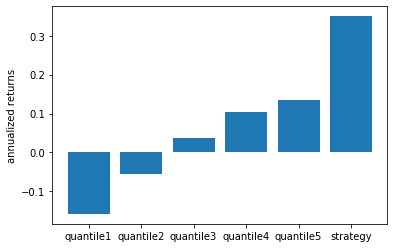

In [329]:

plt.bar(pd.Series(annualized_returns).sort_values(ascending=True).index,pd.Series(annualized_returns).sort_values(ascending=True))

plt.ylabel("Annualized Returns")


In [462]:
# calculate annualized volatility
annualized_std = {}
for quantile in portfolio.columns[0:6]:
    std= np.sqrt(np.var(portfolio[quantile]))
    annualized_std[quantile] = round(std**2*52,3)
print(annualized_std)

{'quantile1': 0.126, 'quantile2': 0.142, 'quantile3': 0.138, 'quantile4': 0.142, 'quantile5': 0.146, 'strategy': 0.015}


Text(0, 0.5, 'Annualized Volatility %')

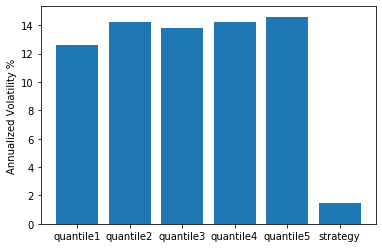

In [465]:
plt.bar(pd.Series(annualized_std).index,pd.Series(annualized_std)*100)
plt.ylabel('Annualized Volatility %')

In [469]:
#calculate factor turnover rate 
def turnover(date, data = factor2):
    try:
        mid = factor2.loc[date].dropna()
        long = list(mid[mid > mid.quantile(0.8)].index)
        short = list(mid[mid < mid.quantile(0.2)].index )
        return long,short
    except:
        print("Please choose another date inside the index")
turns = {}
for i in range(1,len(factor2.index)):
    long1, short1 = turnover(factor2.index[i-1])
    long2, short2 = turnover(factor2.index[i])
    k = len(set(long2).difference(set(long1)))
    l = len(set(short2).difference(set(short1)))
    turns[factor2.index[i]] = (k+l)/len(long2)
    
#print(pd.DataFrame([turns]).T)

{Timestamp('2008-01-11 00:00:00'): 0.7168141592920354, Timestamp('2008-01-18 00:00:00'): 0.6415929203539823, Timestamp('2008-01-25 00:00:00'): 0.7079646017699115, Timestamp('2008-02-01 00:00:00'): 0.6371681415929203, Timestamp('2008-02-05 00:00:00'): 0.34513274336283184, Timestamp('2008-02-15 00:00:00'): 0.42920353982300885, Timestamp('2008-02-22 00:00:00'): 0.4911504424778761, Timestamp('2008-02-29 00:00:00'): 0.5309734513274337, Timestamp('2008-03-07 00:00:00'): 0.5221238938053098, Timestamp('2008-03-14 00:00:00'): 0.5, Timestamp('2008-03-21 00:00:00'): 0.42920353982300885, Timestamp('2008-03-28 00:00:00'): 0.42035398230088494, Timestamp('2008-04-03 00:00:00'): 0.36283185840707965, Timestamp('2008-04-11 00:00:00'): 0.4557522123893805, Timestamp('2008-04-18 00:00:00'): 0.5176991150442478, Timestamp('2008-04-25 00:00:00'): 0.5176991150442478, Timestamp('2008-04-30 00:00:00'): 0.4469026548672566, Timestamp('2008-05-09 00:00:00'): 0.5663716814159292, Timestamp('2008-05-16 00:00:00'): 0.4

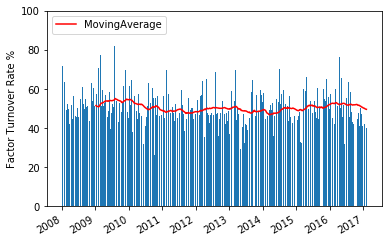

In [471]:
#plot turnover rate
plt.bar(pd.Series(turns).index,pd.Series(turns)*100,width=5)
plt.ylabel("Factor Turnover Rate %")
plt.ylim([0,100])
factorturn = pd.DataFrame.from_dict(turns,orient = 'index',columns = ['turnover'])
factorturn["MovingAverage"] = np.nan
for i in range(51,len(factorturn)):
    factorturn["MovingAverage"][i]=round(factorturn['turnover'][i-51:i].mean(),3)*100

factorturn['MovingAverage'].plot(color = "red")
plt.legend(loc = "upper left")

Text(0, 0.5, 'Information Ratio')

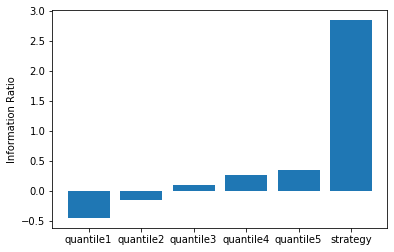

In [448]:
#calculate information ratio
ir = {}
for i in annualized_returns.keys():
    ir[i] = annualized_returns[i]/annualized_std[i]
#plot information ratio
plt.bar(pd.Series(ir).index,pd.Series(ir))
plt.ylabel('Information Ratio')

In [449]:
#provide portfolio returns table
basic = pd.DataFrame(np.zeros((1,6)),columns = portfolio.columns)
port_ret = basic.append(portfolio).reset_index().rename(columns={'index':'date'})
port_ret.date[0] = "basic"
portfolio_returns = port_ret.set_index('date')
#print(port_ret.head())
portfolio_returns.to_csv('Portfolio Returns0426.csv')

/Users/zengzheng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Text(0, 0.5, 'Quantile Returns')

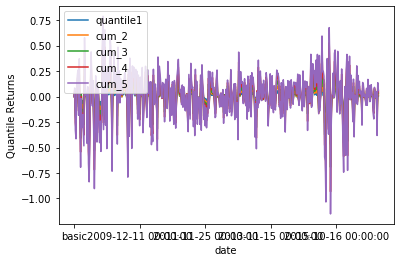

In [450]:
#calculate cumulative quantile returns
portfolio_returns['cum_2'] = portfolio_returns.quantile1+portfolio_returns.quantile2
portfolio_returns['cum_3'] = portfolio_returns.cum_2+portfolio_returns.quantile3
portfolio_returns['cum_4'] = portfolio_returns.cum_3+portfolio_returns.quantile4
portfolio_returns['cum_5'] = portfolio_returns.cum_4+portfolio_returns.quantile5
quantile_ret = portfolio_returns[['quantile1','cum_2','cum_3','cum_4','cum_5']]
quantile_ret.plot()
plt.legend(loc ="upper left")
plt.ylabel("Quantile Returns")

Text(0, 0.5, 'Sortino Ratio %')

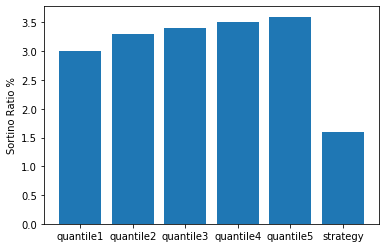

In [451]:
#satino ratio
sortino = {}
fm = lambda x : max(0,x)**2
for quant in portfolio.columns:
    sortino[quant] = round(np.sqrt(portfolio[quant].apply(fm).mean()),3)
    
plt.bar(pd.Series(sortino).index,pd.Series(sortino)*100)
plt.ylabel("Sortino Ratio %")

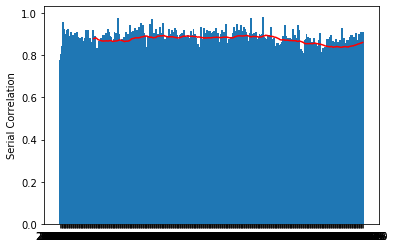

In [456]:
#serial correlation
correlation={}
for i in range(len(factor.columns)-1):
    correlation[factor.columns[i]] = factor[[factor.columns[i],factor.columns[i+1]]].corr().iloc[0,1]
plt.bar(pd.Series(correlation).index,pd.Series(correlation),width=3)
corre_ma = pd.Series(correlation).copy()
corre_ma[0:52] = np.nan
for i in range(51,len(corre_ma)):
    corre_ma[i] = round(pd.Series(correlation)[i-51:i].mean(),3)
plt.ylabel("Serial Correlation")
corre_ma.plot(color="red")

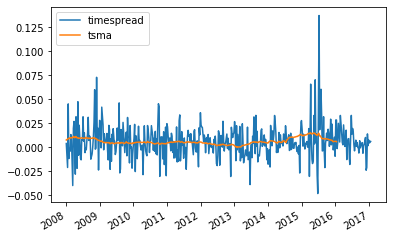

In [457]:
#time spread
portfolio["timespread"] = portfolio.quantile5 - portfolio.quantile1
portfolio['timespread'].plot()
portfolio['tsma'] =np.nan
for i in range(len(portfolio)-51):
    portfolio['tsma'][i] = portfolio['timespread'][i:i+51].mean() 
portfolio['tsma'].plot()
plt.legend(loc="upper left")

Text(0, 0.5, 'Cumulative Wealth Curve')

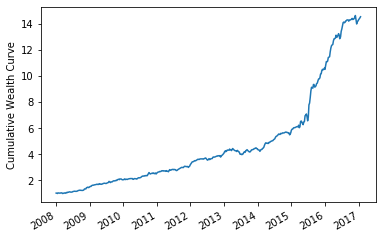

In [458]:
#cumulative curve
portfolio['cumulative_curve'] = np.cumprod(portfolio['strategy']+1)
portfolio.cumulative_curve.plot()
plt.ylabel("Cumulative Wealth Curve")

no date


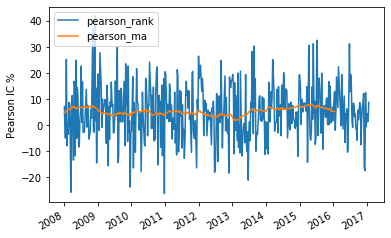

In [459]:
#pearson rank correlation
portfolio['pearson_rank'] = np.nan
for i in factor2.index:
    try:
        factorrank = factor2.loc[i].rank()
        returnrank = freturn.loc[i].rank()
        corre = factorrank.corr(returnrank)
        portfolio.loc[i]['pearson_rank'] = corre
    except:
        print("no date")
pd.Series(portfolio['pearson_rank']*100).plot()
portfolio['pearson_ma'] = np.nan
for i in range(len(portfolio)-51):
    portfolio['pearson_ma'][i] = portfolio['pearson_rank'][i:i+51].mean()*100
portfolio['pearson_ma'].plot()
plt.ylabel("Pearson IC %")
plt.legend(loc="upper left")